# FERS Tutorial Notebook
This notebook presents a tutorial to get FERS noobs up and running quickly.

It is assumed that you are running FERS locally, i.e. `fers` can be run from anywhere in your terminal. Feel free to use the server.sh file if you have a remote setup.

First, import some important modules.

In [458]:
import fers as fers

import os
import matplotlib.pyplot as plt
import numpy as np

from numpy import matlib as mb
from scipy.signal import spectrogram, decimate
from scipy import interpolate

Next, set some constants and default file names.

In [459]:
FERS_INPUT_FILENAME = "up_chirp.h5"
FERS_XML_FILENAME = "sim.fersxml"
FERS_OUTPUT_FILENAME = "receiver.h5"

BOLTZMANN = 1.38064852e-23
c = 299792458

Define a couple of convenience functions.

In [460]:
def lin2db(lin):
    '''
    Conversion from linear to decibels.
    '''
    return 10*np.log10(lin)

def achirp(period, sample_rate, bandwidth, init_freq=0, tau=0, phi=0):
    '''
    Generate an analytic baseband chirp.
    '''
    ns_chirp = int(np.ceil(period*sample_rate))
    t_chirp = np.linspace(-period/2, period/2, ns_chirp, endpoint=False)
    return np.exp(1.j*(np.pi*bandwidth/(2*max(t_chirp))*pow((t_chirp - tau), 2) + 2*np.pi*init_freq*(t_chirp - tau) + phi))

def next_pow_two(number):
    '''
    Returns the next power of two.
    '''
    return int(pow(2, np.ceil(np.log2(number))))

Define the Target class.

In [461]:
class Target:
    def __init__(self, name, x, y, z, t, rcs):
        self.name = name
        self.x = x
        self.y = y
        self.z = z
        self.t = t
        self.rcs = rcs

Now, set parameters about the radar platform.

In [462]:
velocity = 30
height = 1
n_seconds = 1

distance = n_seconds * velocity

#TODO: add real motion to data
diff = np.linspace(0, 15, num=2500)  #required number of samples to run FERS simulation
d = 500 + 100*np.sin(100*np.pi*diff) # 30m sinusoidal deviation in range

# define target motion


waypoints = np.array([
    [0, 0],             # x: swath
    [0, d],             # y: cross range
    [height, height],   # z: altitude
    [0, n_seconds]      # t: time
])

Add as many targets as you please.

In [463]:
targets = []
targets.append(Target(name='A', x=[10], y=[500], z=[10], t=[0], rcs=500))
#targets.append(Target(name='B', x=[10], y=[10], z=[10], t=[0], rcs=100))

Radar parameters are set next.

In [464]:
fc = 2.45e9
wavelength = c/fc
ramp_bandwidth = 100e6 #50e6
adc_rate = 125e6 #100e6
decimation_factor = 40 #100
os_factor = 1
adc_bits = 14 #14
rf_sim_rate = adc_rate * os_factor
tx_power = 10 # watt
noise_temp = 290
noise_density = BOLTZMANN * noise_temp # [W/Hz]

print('Noise density:', np.round(lin2db(noise_density) + 30, 2), '[dBm/Hz]')

prf = 1250 # Hz - was 1000 Hz
ramp_period = 1/prf
bb_sample_rate = adc_rate/decimation_factor

n_pulses = int(prf*n_seconds)
ns_pulse = int(ramp_period*bb_sample_rate)
ns_fft = next_pow_two(ns_pulse)

# time axes
t_rf  = np.linspace(0, ramp_period, int(ramp_period*rf_sim_rate), endpoint=False)
t_adc = np.linspace(0, ramp_period, int(ramp_period), endpoint=False)
t_bb = np.linspace(0, ramp_period, int(ramp_period*bb_sample_rate), endpoint=False)

# range axes
f_fft = np.linspace(-bb_sample_rate/2, bb_sample_rate/2, ns_fft, endpoint=False)
r_fft = ramp_period/ramp_bandwidth * c/2 * f_fft

if (rf_sim_rate < ramp_bandwidth):
    print("Simulation sample rate insufficient, increase the over-sampling factor.")
    exit()

Noise density: -173.98 [dBm/Hz]


Generate and plot the TX waveform.

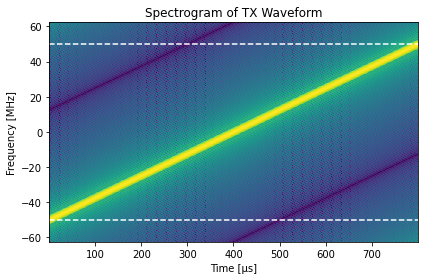

In [465]:
tx_chirp = achirp(
    period = ramp_period,
    sample_rate = rf_sim_rate,
    bandwidth = ramp_bandwidth,
    tau = 0
    )

f, t, spect = spectrogram(
    tx_chirp, 
    fs=rf_sim_rate, 
    nperseg=128, 
    nfft=512, 
    noverlap=0, 
    mode='magnitude', 
    window='blackman', 
    return_onesided=False, 
    detrend=False
)

spect = lin2db(np.abs(spect))
spect -= spect.max()

spect = np.fft.fftshift(spect, axes=0)
t *= 1e6
f = np.fft.fftshift(f)/1e6

plt.figure()
plt.hlines(ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.hlines(-ramp_bandwidth/2e6, t[0], t[-1], linestyles='--', colors='white')
plt.pcolormesh(t, f, spect)
plt.title('Spectrogram of TX Waveform')
plt.xlabel('Time [µs]')
plt.ylabel('Frequency [MHz]')
plt.tight_layout()

Set the spacing between transmit and receive antennas.

In [466]:
antenna_spacing = [0, 0.5, 0]
iso_rx_ft = lin2db(tx_power * pow(wavelength/(4*np.pi*np.sqrt(antenna_spacing[0]**2 + antenna_spacing[1]**2 + antenna_spacing[2]**2)), 2)) + 30
print('Feed-through at isotropic RX antenna:', np.round(iso_rx_ft, 2), '[dBm]')

Feed-through at isotropic RX antenna: 5.79 [dBm]


Generate the FERS XML file and run the simulation.

In [467]:
output_dir = os.path.abspath(os.getcwd())

fers.write_hdf5(tx_chirp, os.path.join(output_dir, FERS_INPUT_FILENAME))

fers_xml = fers.FersXMLGenerator(os.path.join(output_dir, FERS_XML_FILENAME))

fers_xml.add_parameters(
    t_start=1//prf,
    t_end=n_seconds,
    sim_rate=rf_sim_rate,
    bits=adc_bits
    )

fers_xml.add_pulse(
    name='up_chirp',
    pulse_file=FERS_INPUT_FILENAME,
    power_watts=tx_power,
    centre_freq=fc
    )

fers_xml.add_clock(name='clock', frequency=adc_rate, synconpulse='false')

fers_xml.add_antenna(name='tx_rx_antenna', pattern='isotropic')
# fers.add_antenna(name='tx_rx_antenna', pattern='parabolic', d=0.1)
# fers.add_antenna(name='tx_rx_antenna', pattern='sinc', a=pow(10, ANTENNA_GAIN/10), b=2, g=5, is_plot=True)

fers_xml.add_pseudo_monostatic_radar(
    spacing=antenna_spacing,
    waypoints=waypoints,
    antenna='tx_rx_antenna',
    timing='clock',
    prf=prf,
    pulse='up_chirp',
    window_length=ramp_period,
    noise_temp=noise_temp,
    nodirect='true'
)

for target in targets:            
    fers_xml.add_target(
        name = target.name,
        x = target.x,
        y = target.y,
        z = target.z,
        t = target.t,
        rcs = target.rcs
    )
    
fers_xml.write_xml()
fers_xml.run()
del fers_xml

rx_matrix = fers.read_hdf5(FERS_OUTPUT_FILENAME)

/------------------------------------------------\
| FERS - The Flexible Extensible Radar Simulator |
| Version 0.28                                   |
\------------------------------------------------/

[VERBOSE] Loading XML Script File.
[CRITICAL] Propagation speed (c) set to custom value: 299792458.00000
[VV] System sample rate set to custom value: 125000000.00000
[VERBOSE] Using random seed from clock(): 1654701579
[VERBOSE] Quantizing results to 14 bits
[VV] Oversampling enabled with ratio 1
[VV] Generating Pulse up_chirp of type 'file'
[VV] Loading antenna 'tx_rx_antenna' of type 'isotropic'
[VV] Loading timing source 'clock'
[VV] Loading Transmitter: 0
[VV] Loading Receiver: 'receiver' 0
[VV] Ignoring direct signals for receiver 'receiver'
[INFO] Using threaded simulation with 4 threads.
[VERBOSE] Created simulator thread for transmitter 'transmitter' and receiver 'receiver' 1250
[VV] 1250 responses added to receiver 'receiver'
[VV] Created render thread for receiver 'receiver'

Remove receiver.h5 from memory

In [468]:
# delete file
os.system('rm -r ' + FERS_OUTPUT_FILENAME)

0

Perform RF dechirp by mixing RX and DX and filtering result.
Analytic representation eliminates need to filter.

In [469]:
# dx_chirp is a row vector -> repeat over several rows
# now rx_matrix and dx_matrix both have pulses as rows (axis = 1)
dx_matrix = mb.repmat(tx_chirp, n_pulses, 1)

l = rx_matrix.shape[0]
if (l % decimation_factor) == 1:
    rx_matrix = rx_matrix[:l-1,:]

bb_matrix = np.multiply(dx_matrix, np.conjugate(rx_matrix))
# del rx_matrix, dx_matrix

Decimate the data to the final sample rate.

In [470]:
# decimate to ADC rate
bb_matrix = decimate(bb_matrix, os_factor, axis=1, zero_phase=True)
# decimate to final sample rate
bb_matrix = decimate(bb_matrix, decimation_factor, ftype='fir', axis=1)

Transpose the data matrix for pulses down each column.

In [471]:
bb_matrix = np.transpose(bb_matrix)

Plot the time domain beat signal.

/home/tlotliso/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Time (us)')

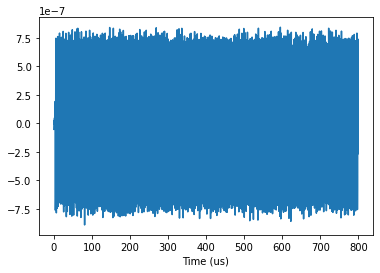

In [472]:
plt.figure()
plt.plot(t_bb*1e6, bb_matrix[:, 0])
plt.xlabel('Time (us)')

Apply a window of your choice to the time domain beat signal.

In [473]:
window_matrix = np.blackman(ns_pulse)

window_matrix = np.transpose(
    np.tile(window_matrix, (n_pulses, 1)))

bb_matrix = np.multiply(bb_matrix, window_matrix)

Take FFT of each beat signal.

In [474]:
bb_matrix = np.fft.fftshift(np.fft.fft(
    bb_matrix, ns_fft, axis=0), axes=0)

Plot a range profile of the pulse in the middle of the experiment.

Text(0.5, 0, 'Range (m)')

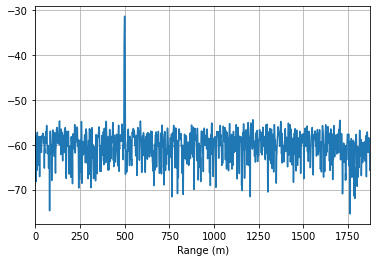

In [475]:
plt.figure()
plt.plot(r_fft, lin2db(abs(bb_matrix[:, n_pulses//2])))
plt.xlim(0, r_fft[-1])
plt.grid()
plt.xlabel('Range (m)')

Generate a range-time-intensity plot of the data matrix.

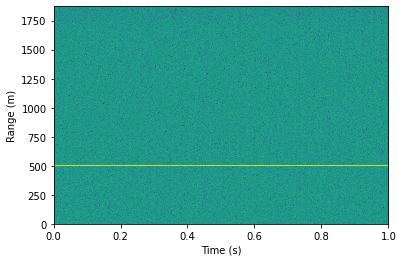

In [476]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    lin2db(abs(bb_matrix)),
    aspect='auto',
    # vmax=vmax,
    # vmin=vmin,
    interpolation='none',
    # cmap=cmap,
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
# ax.grid()
title = 'rti_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

### Motion Compensation by Tlotliso Mapana

Plot signal phase for a single range line

[2.8871746  0.12522688 2.30873259 ... 2.95125123 1.86338714 2.54519971]


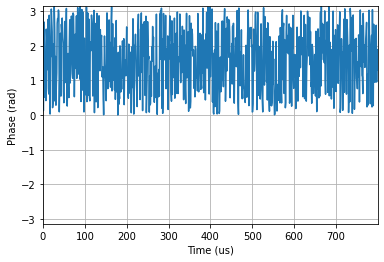

In [477]:
# calculate signal phase
bb_phase = np.angle(bb_matrix)
#print(bb_phase)

phase = np.linspace(-np.pi, np.pi, num=ns_fft, endpoint=False)
r_1 = bb_phase[1,:]
print(abs(r_1))

plt.figure()
plt.plot(abs(r_1))
plt.ylim(phase[0], phase[-1])
plt.xlim(t_bb[0]*1e6, t_bb[-1]*1e6)
plt.xlabel('Time (us)')
plt.ylabel('Phase (rad)')
plt.grid()

Determine nominal range by using a linear fit

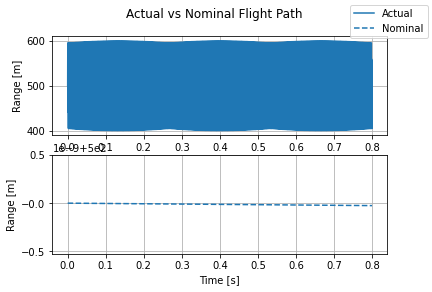

In [478]:
linear_fit = np.polyfit(np.array([t_bb[0], t_bb[-1]]), np.array([d[0], d[-1]]), deg=1)
nominal_range = np.poly1d(linear_fit) # the nominal path the plane should have
nominal_range = nominal_range(t_bb)
nominal_range = np.transpose(nominal_range)

range_dev = np.subtract(nominal_range, d)
#range_dev = np.multiply(-1, range_dev) # to reverse the deviation in range

t = np.linspace(0,1)
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(t_bb*1e3, d, '-', label='Actual')
ax1.set(ylabel='Range [m]')
ax1.grid()

ax2.plot(t_bb*1e3, nominal_range, '--', label='Nominal')
ax2.set(xlabel='Time [s]', ylabel='Range [m]')
fig.suptitle('Actual vs Nominal Flight Path')
fig.legend()
ax2.grid()

Apply corrected range to raw data

In [479]:
delta_phase = np.multiply(4j*np.pi/wavelength, range_dev)
phase_dev = np.exp(delta_phase) # phase deviation of signal
phase_dev = np.fft.fftshift(np.fft.fft(phase_dev, n=ns_fft, axis=0), axes=0)
#phase_dev = np.transpose([phase_dev,])

# convolve with signal
for i in range(0, bb_matrix.shape[1]):
    #for j in range(0, bb_matrix.shape[0]):
    bb_matrix[:,i] = np.convolve(bb_matrix[:,i], phase_dev, mode='same')

bb_mocomp = bb_matrix

Generate a range-time-intensity plot of the motion corrected data

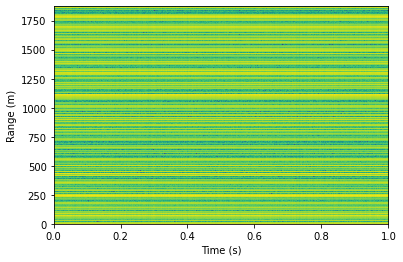

In [480]:
image_axes = [0, n_seconds, r_fft[-1], r_fft[0]]

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(
    lin2db(abs(bb_mocomp)),
    aspect='auto',
    # vmax=vmax,
    # vmin=vmin,
    interpolation='none',
    # cmap=cmap,
    extent=image_axes,
)
ax.set_ylim(0, r_fft[-1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Range (m)')
title = 'rti_mocomp_' + str(height) + 'm.png'
fig.savefig(title, dpi=300)

Plot signal phase for a single range line after proposed motion compensation

[1.2134149  1.88713485 0.10081355 ... 2.46837445 2.83997872 2.67965224]


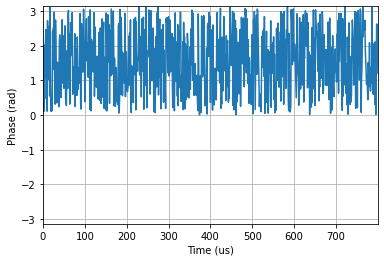

In [481]:
# calculate signal phase
bb_phase_mc = np.angle(bb_mocomp)
r_1_mc = bb_phase_mc[1,:]
print(abs(r_1_mc))

plt.figure()
plt.plot(abs(r_1_mc))
plt.ylim(phase[0], phase[-1])
plt.xlim(t_bb[0]*1e6, t_bb[-1]*1e6)
plt.xlabel('Time (us)')
plt.ylabel('Phase (rad)')
plt.grid()

Range-bin shifting attempt

In [482]:
temp_axes = bb_mocomp.shape
temp = np.zeros(temp_axes[0], temp_axes[1])



TypeError: data type not understood